In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import deepxde as dde
import seaborn as sns

from deepxde.backend import tf
from scipy.integrate import odeint
from math import tanh

sns.set_theme(style="darkgrid")

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term
Enable just-in-time compilation with XLA.



2022-11-14 13:42:32.840811: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-14 13:42:32.882653: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-14 13:42:32.883018: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
def dinn(
    data_t,
    data_y,
    N1,
    N2,
    parameters,
    hyperparameters={
        "search_range": (0.2, 1.8),
        "iterations": 30000,
        "layers": 3,
        "neurons": 64,
        "activation": "relu",
        "loss_weights": None
    }
    
):    
        
    def get_variable_in_search_range(nominal , var, search_range):
        low = nominal * search_range[0]
        up = nominal * search_range[1]
        scale = (up - low) / 2
        tanh_var = tf.tanh(var) if isinstance(var, tf.Variable) else tanh(var)
        return scale * tanh_var + scale + low

    # Variables
    _beta1 = dde.Variable(0.0)
    _omega1 = dde.Variable(0.0)
    _gamma1 = dde.Variable(0.0)
    _beta2 = dde.Variable(0.0)
    _omega2 = dde.Variable(0.0)
    _gamma2 = dde.Variable(0.0)
    _tau12 = dde.Variable(0.0)
    _tau21 = dde.Variable(0.0)
    _delta12 = dde.Variable(0.0)
    _delta21 = dde.Variable(0.0)
    _zeta12 = dde.Variable(0.0)
    _zeta21 = dde.Variable(0.0)
    variables = [
        _beta1,
        _omega1,
        _gamma1,
        _beta2,
        _omega2,
        _gamma2,
        _tau12,
        _tau21,
        _delta12,
        _delta21,
        _zeta12,
        _zeta21
    ]
    
    # ODE model
    def ODE(t, y):
        S1 = y[:, 0:1]
        I1 = y[:, 1:2]
        R1 = y[:, 2:3]
        D1 = y[:, 3:4]
        S2 = y[:, 4:5]
        I2 = y[:, 5:6]
        R2 = y[:, 6:7]
        D2 = y[:, 7:8]
    
        beta1 = get_variable_in_search_range(parameters["beta1"], _beta1, hyperparameters["search_range"])
        omega1 = get_variable_in_search_range(parameters["omega1"], _omega1, hyperparameters["search_range"])
        gamma1 = get_variable_in_search_range(parameters["gamma1"], _gamma1, hyperparameters["search_range"])
        beta2 = get_variable_in_search_range(parameters["beta2"], _beta2, hyperparameters["search_range"])
        omega2 = get_variable_in_search_range(parameters["omega2"], _omega2, hyperparameters["search_range"])
        gamma2 = get_variable_in_search_range(parameters["gamma2"], _gamma2, hyperparameters["search_range"])
        tau12 = get_variable_in_search_range(parameters["tau12"], _tau12, hyperparameters["search_range"])
        tau21 = get_variable_in_search_range(parameters["tau21"], _tau21, hyperparameters["search_range"])
        delta12 = get_variable_in_search_range(parameters["delta12"], _delta12, hyperparameters["search_range"])
        delta21 = get_variable_in_search_range(parameters["delta21"], _delta21, hyperparameters["search_range"])
        zeta12 = get_variable_in_search_range(parameters["zeta12"], _zeta12, hyperparameters["search_range"])
        zeta21 = get_variable_in_search_range(parameters["zeta21"], _zeta21, hyperparameters["search_range"])

        dS1_t = dde.grad.jacobian(y, t, i=0)
        dI1_t = dde.grad.jacobian(y, t, i=1)
        dR1_t = dde.grad.jacobian(y, t, i=2)
        dD1_t = dde.grad.jacobian(y, t, i=3)
        dS2_t = dde.grad.jacobian(y, t, i=4)
        dI2_t = dde.grad.jacobian(y, t, i=5)
        dR2_t = dde.grad.jacobian(y, t, i=6)
        dD2_t = dde.grad.jacobian(y, t, i=7)
        
        return [
            dS1_t - (- beta1 / N1 * S1 * I1 - tau12 * S1 + tau21 * S2 - delta12 / N1 * S1 * I1 - zeta12 / N1 * S1 * I2),
            dI1_t - (beta1 / N1 * S1 * I1 - omega1 * I1 - gamma1 * I1 - tau12 * I1 + tau21 * I2 + delta12 / N1 * S1 * I1 + zeta12 / N1 * S1 * I2),
            dR1_t - (omega1 * I1 - tau12 * R1 + tau21 * R2),
            dD1_t - (gamma1 * I1),
            dS2_t - (- beta2 / N2 * S2 * I2 - tau21 * S2 + tau12 * S1 - delta21 / N2 * S2 * I2 - zeta21 / N2 * S2 * I1),
            dI2_t - (beta2 / N2 * S2 * I2 - omega2 * I2 - gamma2 * I2  - tau21 * I2 + tau12 * I1 + delta21 / N2 * S2 * I2 + zeta21 / N2 * S2 * I1),
            dR2_t - (omega2 * I2 - tau21 * R2 + tau12 * R1),
            dD2_t - (gamma2 * I2)
        ]
    
    # Geometry
    geom = dde.geometry.TimeDomain(data_t[0, 0], data_t[-1, 0])
    
    # Boundaries
    def boundary(_, on_initial):
        return on_initial
    
    # Initial conditions
    ic_S1 = dde.icbc.IC(geom, lambda x: N1- 1, boundary, component=0)
    ic_I1 = dde.icbc.IC(geom, lambda x: 1, boundary, component=1)
    ic_R1 = dde.icbc.IC(geom, lambda x: 0, boundary, component=2)
    ic_D1 = dde.icbc.IC(geom, lambda x: 0, boundary, component=3)
    ic_S2 = dde.icbc.IC(geom, lambda x: N2- 1, boundary, component=4)
    ic_I2 = dde.icbc.IC(geom, lambda x: 1, boundary, component=5)
    ic_R2 = dde.icbc.IC(geom, lambda x: 0, boundary, component=6)
    ic_D2 = dde.icbc.IC(geom, lambda x: 0, boundary, component=7)

    # Train data
    observe_S1 = dde.icbc.PointSetBC(data_t, data_y[:, 0:1], component=0)
    observe_I1 = dde.icbc.PointSetBC(data_t, data_y[:, 1:2], component=1)
    observe_R1 = dde.icbc.PointSetBC(data_t, data_y[:, 2:3], component=2)
    observe_D1 = dde.icbc.PointSetBC(data_t, data_y[:, 3:4], component=3)
    observe_S2 = dde.icbc.PointSetBC(data_t, data_y[:, 4:5], component=4)
    observe_I2 = dde.icbc.PointSetBC(data_t, data_y[:, 5:6], component=5)
    observe_R2 = dde.icbc.PointSetBC(data_t, data_y[:, 6:7], component=6)
    observe_D2 = dde.icbc.PointSetBC(data_t, data_y[:, 7:8], component=7)
    
    # Model
    data = dde.data.PDE(
        geom,
        ODE,
        [
            ic_S1,
            ic_I1,
            ic_R1,
            ic_D1,
            ic_S2,
            ic_I2,
            ic_R2,
            ic_D2,
            observe_S1,
            observe_I1,
            observe_R1,
            observe_D1,
            observe_S2,
            observe_I2,
            observe_R2,
            observe_D2
        ],
        num_domain=0,
        num_boundary=2,
        anchors=data_t,
    )
    
    neurons = hyperparameters["neurons"]
    layers = hyperparameters["layers"]
    activation = hyperparameters["activation"]
    net = dde.nn.FNN([1] + [neurons] * layers + [8], activation, "Glorot uniform")
    
    def feature_transform(t):
        t = t / data_t[-1, 0]
        return t

    net.apply_feature_transform(feature_transform)

    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        loss_weights=hyperparameters["loss_weights"],
        external_trainable_variables=variables
    )
    variable = dde.callbacks.VariableValue(
        variables,
        period=5000,
    )
    model.train(
        iterations=hyperparameters["iterations"],
        display_every=5000,
        callbacks=[variable]
    )

    parameters_pred = {
        name: get_variable_in_search_range(nominal, var, hyperparameters["search_range"])
        for (name, nominal), var in zip(parameters.items(), variable.value)
    }

    return model, parameters_pred


In [13]:
def plot(data_pred, data_real, filepath=None):
    
    sns.set(rc={"figure.facecolor":"white"})
    
    g = sns.relplot(
        data=data_pred,
        x="time",
        y="population",
        row="region",
        hue="status",
        kind="line",
        aspect=2.5,
    )

    for region, ax in g.axes_dict.items():
        sns.scatterplot(
            data=data_real.query("region == @region"),
            x="time",
            y="population",
            hue="status",
            ax=ax,
            legend=False
        )


    (
        g.set_axis_labels("Time", "Population")
        .set_titles("Region {row_name}")
        .tight_layout(w_pad=1)
    )

    g._legend.set_title("Status")
    g.fig.subplots_adjust(top=0.9)
    g.fig.suptitle(f"Estimation SIRD model with transportation and short term cross transmission for Colombia data")
    if filepath is not None:
        plt.savefig(filepath, dpi=300)
    # plt.close()
    return g


In [5]:
data = pd.read_csv("Colombia_Data.csv", sep=";", decimal=",")
data.head()

,Unnamed: 0,Susceptible_Bog,Exposed_Bog,Infected_Bog,Asintomathic_Bog,Quarentine_Bog,Recovery_Bog,Dead_Bog,Susceptible_Med,Exposed_Med,Infected_Med,Asintomathic_Med,Quarentine_Med,Recovery_Med,Dead_Med
0,0,7.180000e+06,1.000000e+03,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,2.568000e+06,1000.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
1,1,6.201442e+06,4.652751e+04,6010.550125,7.671181e+03,4669.779051,1.795261e+03,8.206950e+02,2.547483e+06,4313.538714,660.768075,1037.011876,780.717789,6.156850e+02,97.472142
2,2,3.091846e+06,1.549432e+06,244586.350800,3.544408e+05,232267.052100,1.080517e+05,5.151391e+04,2.194086e+06,134379.442200,21682.967920,35071.850010,26175.177630,2.060832e+04,2791.052066
3,3,8.859796e+04,1.097899e+06,358421.827600,1.295893e+06,908987.180300,1.155359e+06,5.777545e+05,7.328970e+05,564230.729200,118070.277200,300034.482900,232619.889900,3.446380e+05,47290.054760
4,4,1.314318e+04,2.371428e+05,103424.917500,1.134214e+06,482017.027900,2.372624e+06,1.151517e+06,9.948418e+04,254211.991900,74832.312250,402193.337900,248480.374000,1.063525e+06,150004.761600


In [6]:
n_train = 10
y_train = (
    pd.read_csv("Colombia_Data.csv", sep=";", decimal=",").head(n_train)
    .assign(
        I1=lambda x: x["Infected_Bog"] + x["Asintomathic_Bog"],
        I2=lambda x: x["Infected_Med"] + x["Asintomathic_Med"]
    )
    .loc[
        :,
        [
            "Susceptible_Bog",
            "I1",
            "Recovery_Bog",
            "Dead_Bog",
            "Susceptible_Med",
            "I2",
            "Recovery_Med",
            "Dead_Med"
        ]
    ]
    .values
)

In [7]:
t_train = np.arange(0, len(y_train))[:, np.newaxis]
t_pred = np.arange(0, len(y_train), 0.25)[:, np.newaxis]

In [8]:
N1 = 7181000
N2 = 2569000
parameters = {
    "beta1": 0.5,
    "omega1": 1 / 24,
    "gamma1": 1 / 5,
    "beta2": 0.2,
    "omega2": 1 / 14,
    "gamma2": 1 / 5,
    "tau12": 0.04,
    "tau21": 0.019,
    "delta12": 0.029,
    "delta21": 0.01,
    "zeta12": 0.032,
    "zeta21": 0.01
}

hyperparameters = {
    "search_range": (0.2, 1.8),
    "iterations": 30000,
    "layers": 5,
    "neurons": 64,
    "activation": "relu",
    "loss_weights": 8 * [0.1] + 8 * [0.01] + 8 * [1],
}
filepath="sird_ts_colombia.png"

In [9]:
populations_names = ["S1", "I1", "R1", "D1", "S2", "I2", "R2", "D2"]
region_dict = {"1": "Bogotá", "2": "Medellín"}
data_real = (
    pd.DataFrame(y_train, columns=populations_names, index=t_train.ravel())
    .rename_axis("time")
    .reset_index()
    .melt(id_vars="time", var_name="status_region", value_name="population")
    .assign(
        status=lambda x: x["status_region"].str[0],
        region=lambda x: x["status_region"].str[1].map(region_dict),
    )
)

model, parameters_pred = dinn(
    data_t=t_train,
    data_y=y_train,
    N1=N1,
    N2=N2,
    parameters=parameters,
    hyperparameters=hyperparameters
)

y_pred = model.predict(t_pred)
data_pred = (
    pd.DataFrame(y_pred, columns=populations_names, index=t_pred.ravel())
    .rename_axis("time")
    .reset_index()
    .melt(id_vars="time", var_name="status_region", value_name="population")
    .assign(
        status=lambda x: x["status_region"].str[0],
        region=lambda x: x["status_region"].str[1].map(region_dict),
    )
)

fig = plot(data_pred, data_real, filepath)

Compiling model...
Building feed-forward neural network...
'build' took 0.060820 s



/home/aoguedao/mambaforge/envs/pinn/lib/python3.9/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:103: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
2022-11-14 13:42:34.364220: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-14 13:42:34.368500: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-14 13:42:34.368929: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_nod

'compile' took 2.242765 s

Initializing variables...


2022-11-14 13:42:36.576057: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2022-11-14 13:42:36.666290: I tensorflow/compiler/xla/service/service.cc:170] XLA service 0x7fccc4018320 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-11-14 13:42:36.666342: I tensorflow/compiler/xla/service/service.cc:178]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2022-11-14 13:42:36.751382: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-14 13:42:36.794106: I tensorflow/compiler/jit/xla_compilation_cache.cc:478] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2022-11-14 13:42:36.891472: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:263] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


Training model...

Step      Train loss                                                                                                                                                                                                                                          Test loss                                                                                                                                                                                                                                           Test metric
0         [1.77e-07, 5.70e-07, 1.45e-06, 1.89e-08, 8.46e-07, 9.42e-06, 3.37e-08, 3.99e-07, 5.16e+11, 1.00e-02, 0.00e+00, 0.00e+00, 6.60e+10, 1.00e-02, 0.00e+00, 0.00e+00, 9.96e+12, 5.74e+11, 7.18e+12, 1.29e+12, 1.84e+12, 5.53e+10, 1.71e+12, 3.30e+10]    [1.77e-07, 5.70e-07, 1.45e-06, 1.89e-08, 8.46e-07, 9.42e-06, 3.37e-08, 3.99e-07, 5.16e+11, 1.00e-02, 0.00e+00, 0.00e+00, 6.60e+10, 1.00e-02, 0.00e+00, 0.00e+00, 9.96e+12, 5.74e+11, 7.18e+12, 1.29e+12, 1.84e+12, 5.53e+

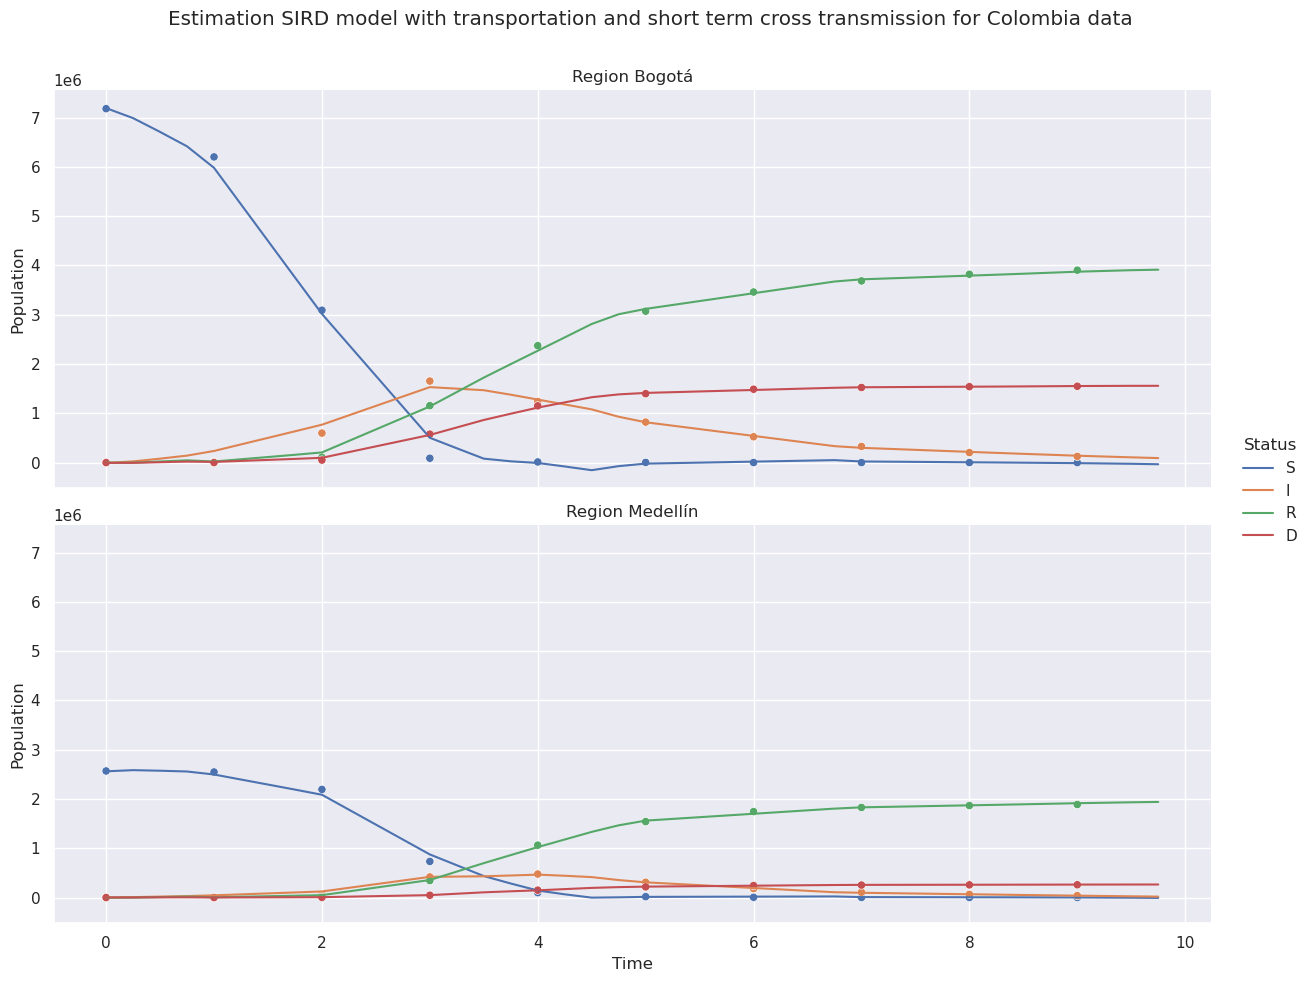

In [14]:
plot(data_pred, data_real, filepath)